In [3]:
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy import *
import scipy.linalg
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.linalg import eig, eigh
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, MDS

import matplotlib.pyplot as plt
import warnings

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [4]:
warnings.simplefilter('ignore')

plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [5]:
dt = 450*10
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7007:7007+dt]
frecuency = len(data)/(data['time'].values[-1]-data['time'].values[0])
assert 480 < frecuency < 520

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
x_acc -= _m
t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

In [6]:
accel_ssa = SSA(x_acc, 500)

x_acc_clear = accel_ssa.reconstruct(slice(0,5))

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [7]:
fig = go.Figure()

fig.add_scatter(y = x_acc,
                mode='lines',
                name='Full')

fig.add_scatter(y = x_acc_clear,
                mode='lines',
                name='0-5')

fig.show()

In [8]:
X = HankelMatrix(x_acc_clear, 500)
X_REAL = HankelMatrix(x_acc, 500)
assert X.shape == X_REAL.shape

In [47]:
embedding = LocallyLinearEmbedding(n_components=3,
                                   n_neighbors=10,
                                   method = 'hessian')

X_transformed = embedding.fit_transform(X)
X_transformed.shape

(4001, 3)

In [46]:
fig_2 = go.Figure()

fig_2.add_trace(go.Scatter3d(x=X_transformed[:,0],
                             y=X_transformed[:,1],
                             z=X_transformed[:,2],
                             marker=dict(size=0.1,
                                         line=dict(width=0.01)
                                        ),
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


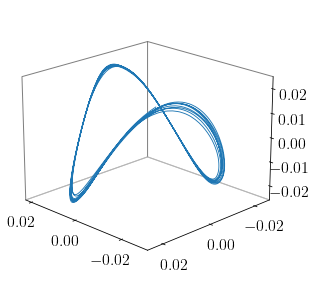

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_transformed[:,0],
        X_transformed[:,1],
        X_transformed[:,2],
        linewidth = 0.9)

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.view_init(elev=20, azim=135)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
fig.savefig('/Users/denistikhonov/Desktop/Study/IAD'
            +'/Research_work/Spherical_Harmonics_parametrisation/doc/figs/phase_hLLE.eps',
            format='eps',
            dpi=600)
plt.show()

In [49]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

In [50]:
X_spherical = TrajectoryToSpherical(X)

In [61]:
X_ = X_spherical[:-1]

model = LocallyLinearEmbedding(n_components=2,
                                 n_neighbors=6,
                                 method = 'hessian')
X_temp = model.fit_transform(X_)

X_SPH = np.concatenate((X_temp,np.ones((len(X_temp),1))),axis = 1)

In [62]:
X_car = TrajectoryToCartesian(X_SPH)

In [63]:
fig_2 = go.Figure()

fig_2.add_trace(go.Scatter3d(x=X_car[:,0],
                             y=X_car[:,1],
                             z=X_car[:,2],
                             marker=dict(size=0.1,
                                         line=dict(width=0.01)
                                        ),
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

# MDS

In [9]:
mds = MDS(n_components=3)
X_mds = mds.fit_transform(X)
X_mds.shape

(4001, 3)

In [10]:
fig_2 = go.Figure()

fig_2.add_trace(go.Scatter3d(x=X_mds[:,0],
                             y=X_mds[:,1],
                             z=X_mds[:,2],
                             marker=dict(size=0.1,
                                         line=dict(width=0.01)
                                        ),
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


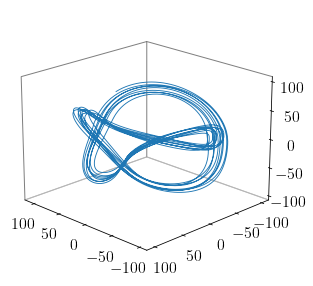

In [38]:
a = -130/180 * np.pi

T_X = np.array([[1,0,0],
                [0,np.cos(a),-np.sin(a)],
                [0,np.sin(a),np.cos(a)]])

T_Y = np.array([[np.cos(a),-np.sin(a),0],
                [np.sin(a),np.cos(a),0],
                [0,0,1]])

T_Z = np.array([[np.cos(a),0,np.sin(a)],
                [0,1,0],
                [-np.sin(a),0,np.cos(a)]])

enc_T = X_mds@T_Z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(enc_T[:,0], enc_T[:,1], enc_T[:,2],linewidth = 0.9)

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.view_init(elev=20, azim=135)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
fig.savefig('/Users/denistikhonov/Desktop/Study/IAD'
            +'/Research_work/Spherical_Harmonics_parametrisation/doc/figs/phase_mds.eps',
            format='eps',
            dpi=600)
plt.show()